# 1. Import all the distributions

In [1]:
%pylab inline --no-import-all
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get distribs and filter bad ones
import distributions

all_distributions_dict = dict([(name, cls) for name, cls in distributions.__dict__.items() if isinstance(cls, type)])
all_distributions_list = [(cls) for name, cls in distributions.__dict__.items() if isinstance(cls, type)]

ok_distributions_list=[]
problems=[]
for i, cls in enumerate(all_distributions_list):
    #print(cls)
    try:
        dist = cls()
        N_test = 100000
        #print('will try to generate for %s' %(cls.__name__))
        if dist.pdf(dist.x_min + .3*(dist.x_max-dist.x_min)) < 1E-3:
            print("may have a problem")
            continue
            
        rvs = dist.rvs(N_test)
        if np.abs(np.mean(rvs) - dist.mean()) > 5*np.std(rvs)/np.sqrt(N_test):
            print("means don't match for %s: %f vs. %f" %(cls.__name__, 
                                                          np.mean(rvs), dist.mean()))
            continue
            
        elif np.abs(np.std(rvs) - dist.std()) > 5*np.std(rvs)/np.sqrt(np.sqrt(1.*N_test)):
            print("std devs. don't match for %s: %f vs. %f" %(cls.__name__, 
                                                          np.std(rvs), dist.std()))
            continue
        elif np.abs(np.std(rvs) - dist.std()) / dist.std() > 0.1:
            print("std devs. don't match for %s: %f vs. %f" %(cls.__name__, 
                                                          np.std(rvs), dist.std()))
            continue
        
        elif np.sum(dist.pdf(np.linspace(dist.x_min,dist.x_max,100))<0) > 0:
            print("pdf was negative in some places")
            continue                    

        else:
            # print("%s passes tests, adding it" %(cls.__name__))
            ok_distributions_list.append(cls)
    except:
        print("%s has errors, does't work" %(cls.__name__))
        continue

print "\nOK distributions: {0}".format([i.__name__ for i in ok_distributions_list])

std devs. don't match for Dist_vag273: 0.144232 vs. 0.288675
std devs. don't match for Dist_pc1727: 0.845127 vs. 1.000000
std devs. don't match for Dist_rdr335: 0.399066 vs. 0.100000
means don't match for Dist_mh3908: 0.856638 vs. 2.364890
std devs. don't match for Dist_ptf223: 2.849401 vs. 2.150000
means don't match for Dist_jeg535: -3.281521 vs. 0.072000
std devs. don't match for Dist_sar653_1: 0.499468 vs. 0.626657
means don't match for Dist_jgc375: 2130.426856 vs. 2130.937950
std devs. don't match for Dist_dl3185: 0.773442 vs. 0.632456
std devs. don't match for Dist_vag273_1: 0.144244 vs. 0.288675
Dist_ae1389 has errors, does't work
may have a problem

OK distributions: ['Dist_sm6376', 'Dist_ry643', 'Dist_yr595', 'Dist_nj18', 'Dist_hk1764', 'Dist_yz2668', 'Dist_psa251', 'Dist_ejk483', 'Dist_my1462', 'Dist_ih646', 'Dist_kc90_2', 'Dist_kc90_3', 'Dist_vag273_2', 'Dist_msc565', 'Dist_jn1348', 'Dist_az1332', 'Dist_kjm538', 'Dist_recast', 'Dist_saw533', 'Dist_jsg549', 'Dist_ac5790']


# 2. Define storage class and assisting functions

Select number of samples to run

In [3]:
N_SAMPLES = 10000
N_BINS    = 50

Let's define a helper class

In [4]:
class Convolution(object):
    
    def __init__(self, distribs, n):
        q = np.zeros(N_SAMPLES)
        var_q = 0.
        mean_q = 0.
        
        print 'Number of iterations: %d' % (n)
        
        for dist_class in np.random.choice(distribs, n):
            dist = dist_class()

            print 'Using: %s ' % (dist_class.__name__)

            q      += dist.rvs(N_SAMPLES)
            var_q  += dist.std() ** 2.
            mean_q += dist.mean()

        std_q = np.sqrt( var_q )

        print '' # spacer
        
        self.dist = q
        self.mu   = mean_q
        self.std  = std_q
        
        cts, bns, patches = plt.hist(self.dist, bins=N_BINS, normed=False, alpha=.2)
        self.counts = cts
        self.bins   = bns
    
    # doesn't depend on outside info; might as well keep this in here
    def centers(self):
        return ((self.bins[1:] + self.bins[:-1]) / 2.) 

... and some helper functions for the class

In [5]:
# Convolution utilities
def binwidth(conv):
    return (conv.bins[1] - conv.bins[0])

def countdiffs(conv):
    print 'Predicted: %f\nCounts: %f' % (np.sum(pdf(conv)), np.sum(conv.counts))
    
def draw(conv):
    plt.plot(conv.centers(), pdf(conv), lw=2, c='r')
    plt.show()

def normfactor(conv):
    return (binwidth(conv) * N_SAMPLES)

# PDF (the expected outcome)
def pdf(conv, plot=False):
    foo = normfactor(conv)*stats.norm.pdf(conv.centers(), loc=conv.mu, scale=conv.std)
    
    if plot:
        plt.plot(conv.centers(), foo)
        plt.xlabel('Predicted distribution curve')
        plt.show()

    return foo

# X2 func
def chi2(conv, tos=False, a=0.05):
    exp = pdf(conv)
    
    if (not tos):
        return np.sum(((conv.counts - exp) ** 2.) / exp)
    else:
        cs_obs, p_val_1 = stats.chisquare(conv.counts, f_exp=exp)
        p_val = stats.chi2.sf(cs_obs, N_BINS)
        
        print 'Using a = %f' % a
    
        if p_val < (a / 100.):
            print 'There is very strong evidence for the data to not match the model'
        elif p_val < (a / 10.):
            print 'There is strong evidence for the data to not match the model'
        elif p_val < (a):
            print 'There is evidence for the data to not match the model'
        else:
            print 'There is not enough evidence for the data to not match the model'

        print 'p-value: {0}\n'.format(p_val)

def chi2testgraph(conv):
    exp  = pdf(conv)
    temp = plt.hist((conv.counts - exp) / np.sqrt(exp), bins=8, normed=True, alpha=0.3)
    
    x = np.linspace(-3, 3, N_SAMPLES)
    
    plt.plot(temp[1], stats.norm.pdf(temp[1]), label='From bins')
    plt.plot(x, stats.norm.pdf(x), label='Theoretical')
    
    plt.legend(loc='upper right')
    plt.show()

# 3. Run convolutions

Number of iterations: 2
Using: Dist_msc565 
Using: Dist_jn1348 



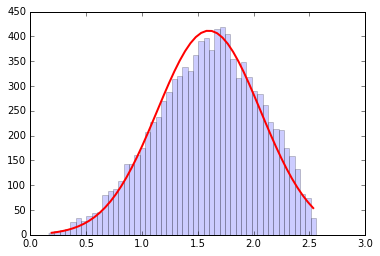

Number of iterations: 4
Using: Dist_ih646 
Using: Dist_yz2668 
Using: Dist_az1332 
Using: Dist_kjm538 



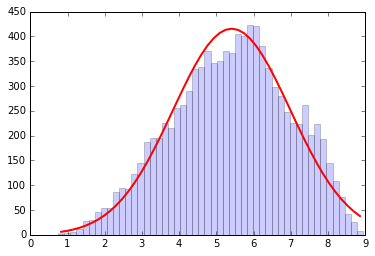

Number of iterations: 8
Using: Dist_ejk483 
Using: Dist_kc90_2 
Using: Dist_ejk483 
Using: Dist_recast 
Using: Dist_recast 
Using: Dist_kc90_3 
Using: Dist_vag273_2 
Using: Dist_psa251 



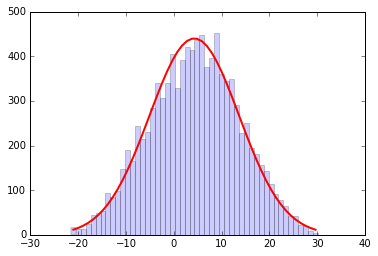

Number of iterations: 16
Using: Dist_psa251 
Using: Dist_hk1764 
Using: Dist_msc565 
Using: Dist_msc565 
Using: Dist_msc565 
Using: Dist_nj18 
Using: Dist_hk1764 
Using: Dist_ejk483 
Using: Dist_yr595 
Using: Dist_ac5790 
Using: Dist_sm6376 
Using: Dist_kjm538 
Using: Dist_ry643 
Using: Dist_jsg549 
Using: Dist_ac5790 
Using: Dist_ac5790 



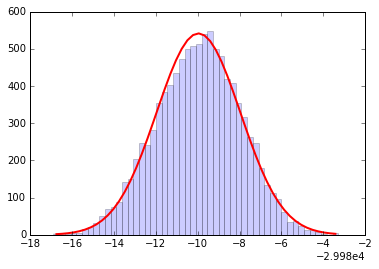

Number of iterations: 32
Using: Dist_az1332 
Using: Dist_hk1764 
Using: Dist_ejk483 
Using: Dist_ejk483 
Using: Dist_saw533 
Using: Dist_jsg549 
Using: Dist_jn1348 
Using: Dist_recast 
Using: Dist_az1332 
Using: Dist_ac5790 
Using: Dist_jn1348 
Using: Dist_ry643 
Using: Dist_kc90_3 
Using: Dist_hk1764 
Using: Dist_kjm538 
Using: Dist_nj18 
Using: Dist_ih646 
Using: Dist_yz2668 
Using: Dist_ejk483 
Using: Dist_saw533 
Using: Dist_yr595 
Using: Dist_kc90_3 
Using: Dist_kjm538 
Using: Dist_jsg549 
Using: Dist_az1332 
Using: Dist_ejk483 
Using: Dist_ry643 
Using: Dist_recast 
Using: Dist_ih646 
Using: Dist_ry643 
Using: Dist_my1462 
Using: Dist_my1462 



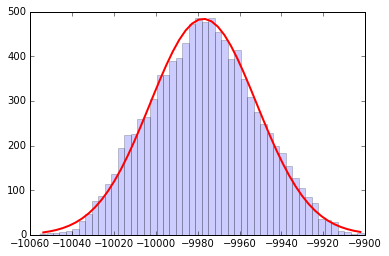

In [29]:
conv2  = Convolution(ok_distributions_list, 2)
draw(conv2)

conv4  = Convolution(ok_distributions_list, 4)
draw(conv4)

conv8  = Convolution(ok_distributions_list, 8)
draw(conv8)

conv16 = Convolution(ok_distributions_list, 16)
draw(conv16)

conv32 = Convolution(ok_distributions_list, 32)
draw(conv32)

# 4. Verify counts to PDF

In [30]:
p2  = pdf(conv2)
p4  = pdf(conv4)
p8  = pdf(conv8)
p16 = pdf(conv16)
p32 = pdf(conv32)

Check if counts match with theoretical PDF

In [31]:
countdiffs(conv2)
countdiffs(conv4)
countdiffs(conv8)
countdiffs(conv16)
countdiffs(conv32)

Predicted: 9797.356695
Counts: 10000.000000
Predicted: 9860.938900
Counts: 10000.000000
Predicted: 9941.895594
Counts: 10000.000000
Predicted: 9992.995702
Counts: 10000.000000
Predicted: 9975.738977
Counts: 10000.000000


# 5. Chi-Squared Test

In [32]:
X2  = chi2(conv2)
X4  = chi2(conv4)
X8  = chi2(conv8)
X16 = chi2(conv16)
X32 = chi2(conv32)

print 'Chi-Squared values: %f, %f, %f, %f, %f' % (X2, X4, X8, X16, X32)

Chi-Squared values: 190.499237, 306.712558, 125.822821, 73.724284, 127.777013


If the $\chi^2$ test is to work, the below graphs must resemble the normal distribution N(0, 1). Ideally, the bins will also match the graph itself. If not, there may be problems.

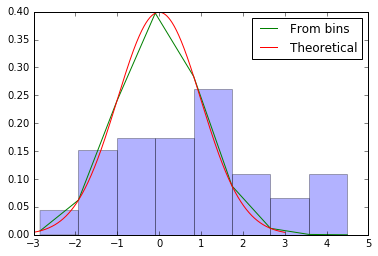

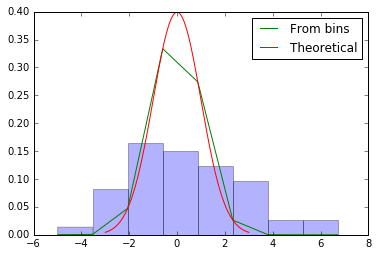

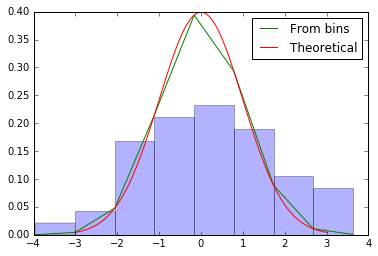

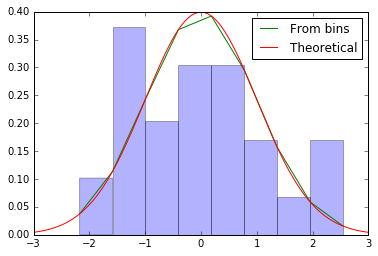

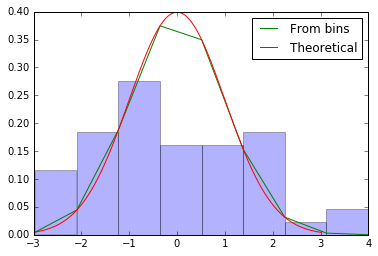

In [33]:
chi2testgraph(conv2)
chi2testgraph(conv4)
chi2testgraph(conv8)
chi2testgraph(conv16)
chi2testgraph(conv32)

Plot number of iterations vs. $\chi^2$ values

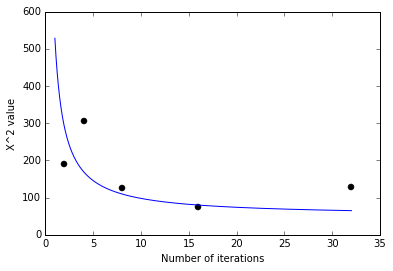

In [35]:
plt.plot(2., X2, 'ko')
plt.plot(4., X4, 'ko')
plt.plot(8., X8, 'ko')
plt.plot(16., X16, 'ko')
plt.plot(32., X32, 'ko')

x = np.linspace(1., 32., N_SAMPLES)
plt.plot(x, (normfactor(conv2) / x) + N_BINS)

plt.xlabel('Number of iterations')
plt.ylabel('X^2 value')

As the number of iterations increases, the $\chi^2$ value approaches the number of degrees of freedom (i.e. the number of bins).